# Project 4 - Team Wiley

Context for the Code Reviewers:

Our team only has 1 coder, and last week/this week has been her RRR/finals week for all her other classes. So the code is sparse, but she will be able to continue working on it starting tomorrow!

### Goals/notes
* Focus on Uganda, families, 2011
* How does demand increase with each individual child?

In [1]:
!pip install CFEDemands --upgrade
!pip install ConsumerDemands
!pip install oauth2client
!pip install eep153_tools
!pip install gnupg
#!pip install dvc

  Using cached CFEDemands-0.4.1-py2.py3-none-any.whl (39 kB)
  Using cached ConsumerDemands-0.3.dev0-py2.py3-none-any.whl (12 kB)
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
  Using cached eep153_tools-0.11-py2.py3-none-any.whl (4.4 kB)
Processing ./.cache/pip/wheels/20/7e/30/7d702acd6a1e89911301cd9dbf9cb9870ca80c0e64bc2cde23/gnupg-2.3.1-py3-none-any.whl


In [2]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Data

In [3]:
InputFiles = {'Expenditures':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','Expenditures'),
              'Consumption':('1RT5AfbZbWx-CmNaOHLp7aD9qEjgjiBv8lZmPexuKEWg','Consumption'),
              'HH Characteristics':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','HH Characteristics'),
              'FCT': ('1DjpLsyhUbQ-giGcTS_GMrDuW_wG3VDrYH1p-FanKxxs','Codes')}

#### Function to read in sheets:

In [4]:
def get_clean_sheet(key,sheet=None):
    dfs = read_sheets(key)
    if sheet is not None:
        df = dfs[sheet]
    else:
        df = dfs.values()[0] 
    df.columns = [c.strip() for c in df.columns.tolist()]
    df = df.loc[:,~df.columns.duplicated(keep='first')]   
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    df = df.loc[~df.index.duplicated(), :]
    return df

#### Expenditure Table

In [5]:
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['j','t','m'])
x.columns.name = 'i'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)



# We only want data from 2011, as that is our focus year:
x_2011 = x[x.index.isin([2011], level=1)]

# Log of expenditure table (x); 
# log table (y) will be used for later estimation:
y_2011 = np.log(x_2011)

Key available for students@eep153.iam.gserviceaccount.com.


#### Household Characteristics Table

In [6]:
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['j','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))



z_2011 = z[z.index.isin([2011], level=1)]

Key available for students@eep153.iam.gserviceaccount.com.


#### Consumption Quantities Table

In [7]:
q = get_clean_sheet(InputFiles['Consumption'][0],
                    sheet=InputFiles['Consumption'][1])

if 'm' not in q.columns:
    q['m'] = 1

q = q.set_index(['j','t','m','u'])
q.columns.name = 'i'

q = q.apply(lambda x: pd.to_numeric(x,errors='coerce'))
q = q.replace(0,np.nan)



q_2011 = q[q.index.isin([2011], level=1)]

Key available for students@eep153.iam.gserviceaccount.com.


#### Food Conversion Table

In [8]:
fct = get_clean_sheet(InputFiles['FCT'][0],sheet=InputFiles['FCT'][1])

fct.index.name = 'i'
foods = fct['Food description']
fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
fct['Food description'] = foods
fct = fct.set_index('Food description')

Key available for students@eep153.iam.gserviceaccount.com.


## Population

* Compare households **in the same income bracket** with **different numbers of children** to understand how demand of nutrients changes per child added to a household
    - We don’t have income levels, we only have household expenditures
    - Does this cause a problem, like if a family of 6 in one income bracket has a similar household expenditure to a family of 6 in a higher income bracket???
    - Be really picky about households, make sure they’re actually very similar
* We might want to take **a couple households with the same number of children each and find an average** (like an average for a household with 2 children, an average for a household with 5 children) and compare averages


Ideas:
* Definitely create filters
    - Children TOTAL filter
    - Adult TOTAL filter
    - Doesn't matter what the breakdown is, as long as children=children and adult=adult for every household in that particular dataset
    - We can call any combo of age breakdowns with this system
* Look up income data in a separate place? Will it even be household specific tho, to the same household id's that we have here?

In [9]:
# Make a column with total count of children, and one with total count of adults:
z_count = z_2011
z_count["Children"], z_count["Adults"] = [(z_2011["M 0-3"] + z_2011["F 0-3"] + 
                                           z_2011["M 4-8"] + z_2011["F 4-8"] +
                                           z_2011["M 9-13"] + z_2011["F 9-13"] +
                                           z_2011["M 14-18"] + z_2011["F 14-18"]),
                                          (z_2011["M 19-30"] + z_2011["F 19-30"] + 
                                           z_2011["M 31-50"] + z_2011["F 31-50"] +
                                           z_2011["M 51+"] + z_2011["F 51+"])]

/tmp/ipykernel_24/2959427395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_count["Children"], z_count["Adults"] = [(z_2011["M 0-3"] + z_2011["F 0-3"] +


In [10]:
z_count

,,k,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Children,Adults
j,t,m,,,,,,,,,,,,,,,,
1013000201,2011,1,0,1,2,1,0,0,0,0,0,0,1,1,1,0,5,2
1013000202,2011,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,2,1
1013000204,2011,1,0,0,0,0,0,1,0,1,2,0,0,0,1,0,3,2
1013000206,2011,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3
1013000210,2011,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010730012030203,2011,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,2
3010730016100203,2011,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2
3010830020020503,2011,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,3


In [11]:
# Manually looking at households WITH children and seeing what child/adult breakdowns we're interested in:
filter_kid = z_count["Children"]!=0
z_kids = z_count[filter_kid]
df_analyze = z_kids[['Children', 'Adults']]

# Uncomment to look at it again:
# df_analyze.head(60)

Now what dataframes should we create to focus on? We can do any combination of adults and children in a house;
* _**Focus on houses with just 2 adults**_, as a control measure (and because it's overwhelmingly common)
    - But that could be a bit biased; there are some households with many adults, perhaps multi-family households. These could be more likely to be low-income (living together to support each other), and we are just omitting them from the get-go. Something to note !
* Look at the difference from 2 kids to 3, to 4... perhaps 4 to 5?
* Do analysis regardless of income level? Because we don't know it? Just get an average 

In [12]:
# 0 kids filter:
filter0 = z_count["Children"]==0

# 1 kid filter:
filter1 = z_count["Children"]==1

# 2 kids filter:
filter2 = z_count["Children"]==2

# 3 kids filter:
filter3 = z_count["Children"]==3

# 4 kids filter:
filter4 = z_count["Children"]==4

# 5 kids filter:
filter5 = z_count["Children"]==5

# 6 kids filter:
filter6 = z_count["Children"]==6


# Only 2 adults filter:
filter_adult = z_count["Adults"]==2

In [13]:
# Use filters in different combinations to get 4 different dataframes:

zero_kid = z_count[filter0 & filter_adult]

one_kid = z_count[filter1 & filter_adult]

two_kid = z_count[filter2 & filter_adult]

three_kid = z_count[filter3 & filter_adult]

four_kid = z_count[filter4 & filter_adult]

five_kid = z_count[filter5 & filter_adult]

six_kid = z_count[filter6 & filter_adult]

In [14]:
# Function to get household id numbers from any dataframe
def get_ids(df):
    multiple_list = list(df.index.values)
    return [i[0] for i in multiple_list]


# Function to get total expenditures of any dataframe
def get_total_exp(df):
    return (df.sum(axis = 1)).to_frame('Total Exp').droplevel(level=[1,2])
# get rid of droplevel ^ if that ends up being a matching problem


# Function to get a total average expenditure for all households, for a dataframe like that ^
def average_exp(df):
    list_exp = df['Total Exp'].tolist()
    return sum(list_exp)/len(list_exp)

### 0 children, 2 adult households:

In [15]:
# Pull a list of household ID's from the initial family breakdowns:
# (we will use a more refined ID list once we know what households to drop for having all NaN expenditure values)
zero_kid_rough_ids = get_ids(zero_kid)

# Getting expenditure dataframe just for this family breakdown, and dropping the ones with no expenditure data:
zero_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(zero_kid_rough_ids)]).dropna(axis=0, how='all')

# TOTAL sum expenditure per household:
zero_kid_total_x = get_total_exp(zero_kid_x)

zero_kid_ids = get_ids(zero_kid_x)

print('Number of 0 child/2 adult households WITH expenditure data: ', len(zero_kid_x))

Number of 0 child/2 adult households WITH expenditure data:  80


### 1 child, 2 adult households:

In [16]:
# Repeat above for each household breakdown:
one_kid_rough_ids = get_ids(one_kid)
one_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(one_kid_rough_ids)]).dropna(axis=0, how='all')
one_kid_total_x = get_total_exp(one_kid_x)
one_kid_ids = get_ids(one_kid_x)

print('Number of 1 child/2 adult households WITH expenditure data: ', len(one_kid_x))

Number of 1 child/2 adult households WITH expenditure data:  142


### 2 child, 2 adult households:

In [17]:
two_kid_rough_ids = get_ids(two_kid)
two_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(two_kid_rough_ids)]).dropna(axis=0, how='all')
two_kid_total_x = get_total_exp(two_kid_x)
two_kid_ids = get_ids(two_kid_x)

print('Number of 2 child/2 adult households WITH expenditure data: ', len(two_kid_x))

Number of 2 child/2 adult households WITH expenditure data:  190


### 3 child, 2 adult households:

In [18]:
three_kid_rough_ids = get_ids(three_kid)
three_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(three_kid_rough_ids)]).dropna(axis=0, how='all')
three_kid_total_x = get_total_exp(three_kid_x)
three_kid_ids = get_ids(three_kid_x)

print('Number of 3 child/2 adult households WITH expenditure data: ', len(three_kid_x))

Number of 3 child/2 adult households WITH expenditure data:  226


### 4 child, 2 adult households:

In [19]:
four_kid_rough_ids = get_ids(four_kid)
four_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(four_kid_rough_ids)]).dropna(axis=0, how='all')
four_kid_total_x = get_total_exp(four_kid_x)
four_kid_ids = get_ids(four_kid_x)

print('Number of 4 child/2 adult households WITH expenditure data: ', len(four_kid_x))

Number of 4 child/2 adult households WITH expenditure data:  216


### 5 child, 2 adult households:

In [20]:
five_kid_rough_ids = get_ids(five_kid)
five_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(five_kid_rough_ids)]).dropna(axis=0, how='all')
five_kid_total_x = get_total_exp(five_kid_x)
five_kid_ids = get_ids(five_kid_x)

print('Number of 5 child/2 adult households WITH expenditure data: ', len(five_kid_x))

Number of 5 child/2 adult households WITH expenditure data:  184


### 6 child, 2 adult households:

In [21]:
six_kid_rough_ids = get_ids(six_kid)
six_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(six_kid_rough_ids)]).dropna(axis=0, how='all')
six_kid_total_x = get_total_exp(six_kid_x)
six_kid_ids = get_ids(six_kid_x)

print('Number of 6 child/2 adult households WITH expenditure data: ', len(six_kid_x))

Number of 6 child/2 adult households WITH expenditure data:  108


Now income? or no?
* If we take the average of each dataframe's expenditures, we'll get a rough picture of how expenditures increase, and because we can't get income data, taking an average of ALL households with this child breakdown will give us a rough picture still

In [22]:
exp_data = {'Num Kids':[0, 1, 2, 3, 4, 5, 6],
        'Avg Expenditure (UGX)':[average_exp(zero_kid_total_x), average_exp(one_kid_total_x), average_exp(two_kid_total_x), average_exp(three_kid_total_x), average_exp(four_kid_total_x), average_exp(five_kid_total_x), average_exp(six_kid_total_x)]}

exp_table = pd.DataFrame(exp_data)


In [23]:
exp_table

,Num Kids,Avg Expenditure (UGX)
0,0,21588.062500
1,1,27643.239437
2,2,26814.578947
3,3,25776.360619
4,4,26222.893519
5,5,29320.538043
6,6,30356.111111


In [24]:
# Conversion for picturing it better: 
# 1 UGX = 0.000282670 USD

exp_table['Avg Expenditure (USD)'] = exp_table['Avg Expenditure (UGX)']*0.000282413

#### Conversions for Context:

In [25]:
exp_table

,Num Kids,Avg Expenditure (UGX),Avg Expenditure (USD)
0,0,21588.062500,6.096749
1,1,27643.239437,7.806810
2,2,26814.578947,7.572786
3,3,25776.360619,7.279579
4,4,26222.893519,7.405686
5,5,29320.538043,8.280501
6,6,30356.111111,8.572960


## Picturing Average Expenditure per Week

Text(0, 0.5, 'Average Household Expenditure (in UGX)')

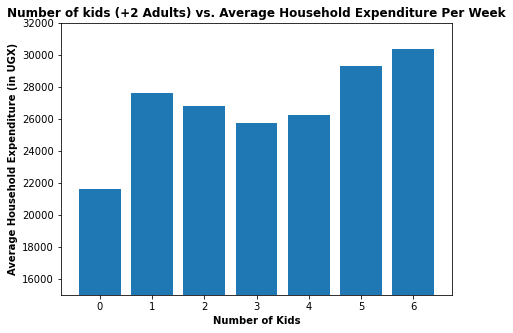

In [26]:
num_kids = exp_table['Num Kids'].to_list()
exp = exp_table['Avg Expenditure (UGX)'].to_list()
 
# Figure Size
fig, ax = plt.subplots(figsize =(7, 5))
 
# Horizontal Bar Plot
ax.bar(num_kids, exp)

ax.set_title('Number of kids (+2 Adults) vs. Average Household Expenditure Per Week', fontweight='bold', fontsize=12)

ax.set_ylim([15000, 32000])

plt.xlabel('Number of Kids', fontweight='bold')
plt.ylabel('Average Household Expenditure (in UGX)', fontweight='bold')


## Estimate Demand System

In [27]:
one_kid_z = (z_2011[z_2011.index.get_level_values('j').isin(one_kid_ids)]).drop(['Children', 'Adults'], axis=1)
one_kid_y = np.log(one_kid_x)

three_kid_z = (z_2011[z_2011.index.get_level_values('j').isin(three_kid_ids)]).drop(['Children', 'Adults'], axis=1)
three_kid_y = np.log(three_kid_x)

five_kid_z = (z_2011[z_2011.index.get_level_values('j').isin(five_kid_ids)]).drop(['Children', 'Adults'], axis=1)
five_kid_y = np.log(five_kid_x)

In [28]:
# Create reduced form
import cfe

result_one = cfe.Result(y=one_kid_y, z=one_kid_z)
result_three = cfe.Result(y=three_kid_y, z=three_kid_z)
result_five = cfe.Result(y=five_kid_y, z=five_kid_z)

Missing dependencies for OracleDemands.


In [29]:
# run this to be able to run the next few lines:
result_one.get_reduced_form()
result_three.get_reduced_form()
result_five.get_reduced_form()

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (2011, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:457: RuntimeWarning: invalid value encountered in sqrt
  sed[Item]=pd.Series(np.sqrt(np.diag(V[Item])), index=z.columns) # reduced form se on characteristics


### Delta Values

#### ONE CHILD HOUSEHOLDS:

In [30]:
# uncomment to see
# result_one.delta.to_dataframe().unstack('k')

#### THREE CHILD HOUSEHOLDS:

In [31]:
# uncomment to see
# result_three.delta.to_dataframe().unstack('k')

#### FIVE CHILD HOUSEHOLDS:

In [32]:
# uncomment to see
# result_three.delta.to_dataframe().unstack('k')

### Alpha Values

#### ONE CHILD HOUSEHOLDS:

In [33]:
result_one.a.to_dataframe().unstack('i')

a                                                          \
i        cooking oil    fresh milk   maize flour        onions          rice   
t    m                                                                         
2011 1  1.736885e+14  2.479924e+15  1.962522e+14  4.220186e+14  4.975309e+14   

                                                            
i               salt     sugar           tea      tomatoes  
t    m                                                      
2011 1  3.694983e+14  7.791682  6.639162e+14  8.080980e+14

#### THREE CHILD HOUSEHOLDS:

In [34]:
result_three.a.to_dataframe().unstack('i')

a                                                          \
i          beans dry          beef   cooking oil   maize flour        onions   
t    m                                                                         
2011 1 -4.772796e+14 -5.460487e+14  5.248491e+14  2.152473e+14  2.907106e+14   

                                                                
i               salt         sugar           tea      tomatoes  
t    m                                                          
2011 1 -1.460945e+14 -5.032084e+14  3.435509e+14 -4.845234e+13

#### FIVE CHILD HOUSEHOLDS:

In [35]:
result_five.a.to_dataframe().unstack('i')

a                                                        \
i        cooking oil    fresh milk maize flour        onions          salt   
t    m                                                                       
2011 1  2.409541e+13 -2.047719e+15    8.394634 -9.192232e+13 -2.619635e+14   

                                                  
i              sugar           tea      tomatoes  
t    m                                            
2011 1 -9.850061e+13  7.830396e+13 -1.529472e+15

### Beta Values

#### ONE CHILD HOUSEHOLDS:

In [36]:
beta_one = result_one.get_beta(as_df=True)
beta_one

i
cooking oil    0.233073
fresh milk     0.783953
maize flour    0.205807
onions         0.378130
rice           0.314677
salt           0.162821
sugar          0.257697
tea            0.514285
tomatoes       0.456100
Name: beta, dtype: float64

#### THREE CHILD HOUSEHOLDS:

In [37]:
beta_three = result_three.get_beta(as_df=True)
beta_three

i
beans dry      0.023871
beef           0.048439
cooking oil    0.451476
maize flour   -0.453853
onions         0.592390
salt           0.002226
sugar          0.342707
tea            0.429852
tomatoes       0.461831
Name: beta, dtype: float64

#### FIVE CHILD HOUSEHOLDS:

In [38]:
beta_five = result_five.get_beta(as_df=True)
beta_five

i
cooking oil   -0.115061
fresh milk    -0.936009
maize flour    0.761110
onions         0.059845
salt           0.165971
sugar         -0.276508
tea            0.467735
tomatoes       0.078094
Name: beta, dtype: float64

## Visualize Some Demand:

Look at:
* maize flour 
* tomatoes
* tea

In [39]:
# Put demand values into dataframes to pull from by name of good:

beta_one_df = beta_one.to_frame().reset_index().rename(columns= {'i': 'good'})
beta_three_df = beta_three.to_frame().reset_index().rename(columns= {'i': 'good'})
beta_five_df = beta_five.to_frame().reset_index().rename(columns= {'i': 'good'})

In [40]:
# Create a dataframe to compare beta values for a single good for all household breakdowns:

def beta_df(good):
    values = []
    for df in [beta_one_df, beta_three_df, beta_five_df]:
        values.append(df[df['good'] == good].iloc[0]['beta'])
    return pd.DataFrame([[1, values[0]], [3, values[1]], [5, values[2]]], columns = ['Children', 'Beta'])

In [41]:
maize_flour_beta = beta_df('maize flour')
tomatoes_beta = beta_df('tomatoes')
tea_beta = beta_df('tea')
cooking_oil_beta = beta_df('cooking oil')
onions_beta = beta_df('onions')
salt_beta = beta_df('salt')
sugar_beta = beta_df('sugar')

In [42]:
def make_beta_bar(df, good):
    children = df['Children'].to_list()
    betas = df['Beta'].to_list()
    
    # Figure Size
    fig, ax = plt.subplots(figsize =(5, 5))
    
    x1, y1 = [0, 6], [0, 0]
    plt.plot(x1, y1, marker = 'o')

    col = []
    for val in betas:
        if val < 0:
            col.append('red')
        else:
            col.append('green')
    
    # Horizontal Bar Plot
    plt.bar(children, betas, color = col)
    

    ax.set_ylim([-0.4, 0.8])

    ax.set_title('Number of kids vs. Beta Value for ' + good, fontweight='bold', fontsize=10)

    plt.xlabel('Number of Kids', fontweight='bold')
    plt.ylabel('Beta Values for ' + good, fontweight='bold')
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

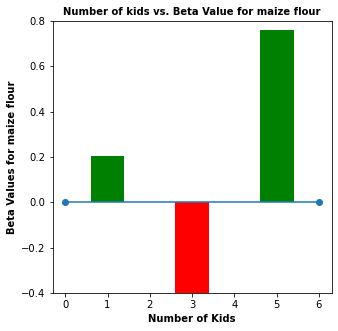

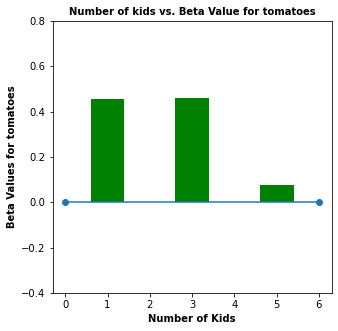

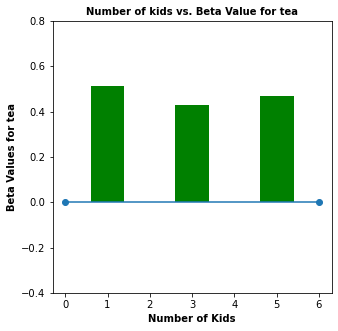

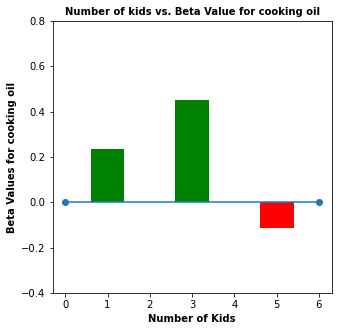

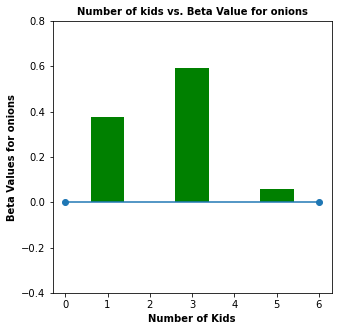

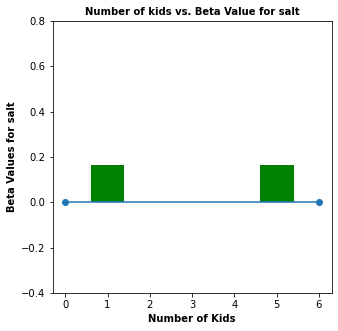

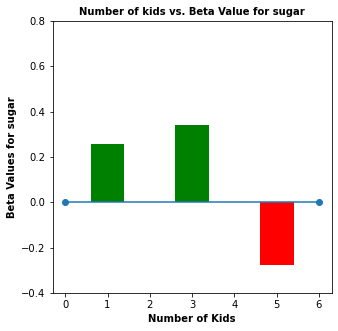

In [43]:
make_beta_bar(maize_flour_beta, 'maize flour')
make_beta_bar(tomatoes_beta, 'tomatoes')
make_beta_bar(tea_beta, 'tea')

make_beta_bar(cooking_oil_beta, 'cooking oil')
make_beta_bar(onions_beta, 'onions')
make_beta_bar(salt_beta, 'salt')
make_beta_bar(sugar_beta, 'sugar')

## Nutritional Adequacy Stuff

Note: All this code was written by someone now in another group: do we want to rewrite?? Not sure. Yes I might

*Deliverables:*
* **[A] Construct Nutrient System:** If you can describe quantities demanded as a function of prices, budgets, and household characteristics, and map quantities into nutrients, then you can also describe a system of nutrients as a function of the same variables

* **[A] Nutritional challenges & Policy Goal:** Compare predicted nutrition to recommended nutrition. Establish some criteria for deciding what the biggest nutritional challenges are for this population. For example, what share of households is Calorie deficient? Is protein deficient? Is Vitamin A deficient? Note that different criteria are possible, and there is no one “right” criterion. Characterize the nutritional challenges you observe in your data, and construct a policy goal to address some of these challenges (e.g., reduce the proportion of households that are protein deficient by half). 


In [13]:
foods = result.i.to_dataframe()
nutrients = fct[fct.index.isin(list(foods.index.values))]
q_items = q.loc[:,list(foods.index.values)]
q_items['Sum'] = q_items.sum(axis=1)
q_items = q_items[q_items['Sum']>0]
q_items = q_items.drop('Sum',axis=1)

In [14]:
diet_req = pd.read_csv("dietary_req.csv").drop(['Source'],axis=1)
dietreq = diet_req.set_index('Nutrition')
dietreq.iloc[len(dietreq)-1,:] = dietreq.iloc[len(dietreq)-1,:] * -1
diet_req = diet_req[diet_req['Nutrition'].isin(['Energy','Protein','Calcium, Ca','Iron, Fe', 'Magnesium, Mg','Vitamin A, RAE','Vitamin B-12','Vitamin B-6','Vitamin C, total ascorbic acid','Zinc, Zn','Vitamin E (alpha-tocopherol)'])]

In [15]:
# Definition functions 

def return_household(row):
    household = np.array([])
    for j in range(len(row)):
        if row[j] == 1:
            if (row.index[j] != 'M 0-3') & (row.index[j] != 'F 0-3'):
                household = np.append(household,row.index[j])
    return household

def return_nutrition(household):
    nut_pd = pd.DataFrame(np.array(np.zeros(len(diet_req['Nutrition']))),index=diet_req['Nutrition'])
    for i in range(len(household)): 
        req = diet_req.loc[:,household[i]]
        nut_pd['Person'+ str(i)] = req.to_list()
    nut_pd['Sum'] = nut_pd.sum(axis=1)
    return nut_pd

def actual_consumption(row):
    total_nut = np.zeros(11)
    for j in range(len(row)):
        nut = np.array(np.zeros(11))
        if row[j] > 0:
            nut = (fct.loc[q_items.columns[j]].array * int(row[j]))
        total_nut = total_nut + nut[0:11]
    return total_nut

def is_adequate(num):
    household = return_household(z.iloc[num])
    nut_req = return_nutrition(household)
    act_req = actual_consumption(q_items.iloc[num])
    adeq = False
    if nut_req['Sum'].to_list() < act_req:
        adeq = False
    else: 
        adeq = True
    return adeq

In [16]:
adequate = 0
for i in range(len(q_items)):
    if is_adequate(i):
        adequate = adequate + 1

IndexError: single positional indexer is out-of-bounds